In [ ]:
#https://www.kaggle.com/c/invasive-species-monitoring/data
#last run @ may 30 2017
#@yvan

# todo

1. get data organized/downloaded 
2. get keras setup with basic model
3. make model better with simple stuff
4. submit to kaggle

In [3]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
print(CUR_DIR, DATA_DIR)

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


In [ ]:
%mkdir -p $DATA_DIR
%cd $DATA_DIR
!kg config -g -c 'invasive-species-monitoring'
!kg download 

In [ ]:
%ls $DATA_DIR

In [ ]:
%cd $DATA_DIR
!module load centos/7
!7za x '*.7z'
!unzip -q *.zip

In [ ]:
%ls -lah $DATA_DIR
%ls -lah $DATA_DIR/train | head -n 25
%ls -lah $DATA_DIR/test  | head -n 25
%ls -l $DATA_DIR/train/*.jpg | wc -l
%ls -l $DATA_DIR/test/*.jpg | wc -l

In [ ]:
%mkdir -p $DATA_DIR/valid

In [ ]:
%cd $DATA_DIR
g = glob('train/*.jpg')
shuf = np.random.permutation(g)
for f in range(len(g)//5):
    os.rename(shuf[f], os.path.join('valid', shuf[f][6:]))

%ls -l $DATA_DIR/valid | wc -l

In [ ]:
%cd $DATA_DIR
tr_labels_df = pd.read_csv('train_labels.csv')
tr_labels_df.head()

In [ ]:
%mkdir -p $DATA_DIR/train/0 $DATA_DIR/train/1
%mkdir -p $DATA_DIR/valid/0 $DATA_DIR/valid/1

In [ ]:
%cd $DATA_DIR
gt = glob('train/*.jpg')
gv = glob('valid/*.jpg')
gt[:5]

In [ ]:
#move training exmaples into 
#classes folders
for f in gt:
    old = os.path.join(f)
    row = tr_labels_df[tr_labels_df['name'] == int(f[6:].split('.')[0])]
    new = os.path.join('train', str(row['invasive'].iloc[0]), str(row['name'].iloc[0])+'.jpg')
    os.rename(old,new)    

In [ ]:
#move validation examples
#into classes folders
for f in gv:
    old = os.path.join(f)
    row = tr_labels_df[tr_labels_df['name'] == int(f[6:].split('.')[0])]
    new = os.path.join('valid', str(row['invasive'].iloc[0]), str(row['name'].iloc[0])+'.jpg')
    os.rename(old,new)  

In [ ]:
%ls -lah $DATA_DIR/train
%ls -lah $DATA_DIR/valid

In [ ]:
%ls -lah $DATA_DIR/train/* | wc -l
%ls -lah $DATA_DIR/valid/* | wc -l

In [ ]:
%mkdir $DATA_DIR/results

In [33]:
%mkdir -p $DATA_DIR/test/unknown
%mv $DATA_DIR/test/*.jpg $DATA_DIR/test/unknown/

In [2]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [72]:
import os
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import FileLink

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
print(CUR_DIR, DATA_DIR)

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
batch_size = 64

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


In [35]:
gen = image.ImageDataGenerator()
tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(150,200), 
                                     class_mode='categorical', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = gen.flow_from_directory(valid_path, 
                                     target_size=(150,200), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

te_batches = gen.flow_from_directory(test_path, 
                                     target_size=(150,200), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [6]:
va_classes = va_batches.classes
tr_classes = tr_batches.classes
va_labels = to_categorical(va_classes)
tr_labels = to_categorical(tr_classes)
va_filenames = va_batches.filenames
tr_filenames = tr_batches.filenames

In [65]:
model = Sequential([
    BatchNormalization(input_shape=(150,200,3)),
    ZeroPadding2D((1, 1), input_shape=(150,200,3)),
    Convolution2D(64, (3, 3), activation='relu'),
    ZeroPadding2D((1, 1)),
    Convolution2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    BatchNormalization(),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [66]:
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=1)

Epoch 1/1
29/29 [==============================] - 634s - loss: 0.5660 - acc: 0.7819 - val_loss: 1.1664 - val_acc: 0.6667


In [ ]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)

In [76]:
preds[:,1]

array([ 0.94361967,  0.9714641 ,  0.99734229, ...,  0.96236449,
        0.99127018,  0.97317016], dtype=float32)

In [209]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [196]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [197]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [198]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [199]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.9436196684837341
1,47,0.9714640974998474
2,966,0.9973422884941101
3,1526,0.946323812007904
4,487,0.9476625919342041


In [200]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_may_27_2017.gz'), index=False, compression='gzip')

In [201]:
%ls -lah $DATA_DIR/results

total 28K
drwxr-x--- 2 yns207 yns207 4,0K 27 mai   11:07 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz


In [ ]:
# this gets a score of 0.72519 on leaderboard
# thats 85th out of 100

In [242]:
# lets try with the functional api
inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(64, (3,3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(64, (3,3), activation='relu')(m)
m = BatchNormalization()(m)
m = MaxPooling2D((3,3))(m)
m = Flatten()(m)
m = Dense(100, activation='relu')(m)
m = BatchNormalization()(m)
preds = Dense(2, activation='softmax')(m)
model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [243]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 200, 3)       0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 150, 200, 3)       12        
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 152, 202, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 150, 200, 64)      1792      
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 152, 202, 64)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 150, 200, 64)      36928     
_________________________________________________________________
batch_normalization_61 (Batc (None, 150, 200, 64)      256       
__________

In [244]:
hist = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=5)

Epoch 1/5
29/29 [==============================] - 804s - loss: 0.5689 - acc: 0.7521 - val_loss: 1.8391 - val_acc: 0.6797
Epoch 2/5
29/29 [==============================] - 792s - loss: 0.3545 - acc: 0.8487 - val_loss: 0.9974 - val_acc: 0.6950
Epoch 3/5
29/29 [==============================] - 792s - loss: 0.2556 - acc: 0.9007 - val_loss: 0.6623 - val_acc: 0.7190
Epoch 4/5
29/29 [==============================] - 791s - loss: 0.1551 - acc: 0.9504 - val_loss: 0.6189 - val_acc: 0.7081
Epoch 5/5
29/29 [==============================] - 793s - loss: 0.0605 - acc: 0.9922 - val_loss: 0.4841 - val_acc: 0.7582


In [245]:
model.evaluate_generator(va_batches, steps=(va_batches.n//batch_size)+1, workers=2)

[0.48410871306795439, 0.75816993464052285]

In [246]:
hist.history

{'acc': [0.75163398731767739,
  0.84858387825535797,
  0.90032679751547851,
  0.94989106753812635,
  0.99237472818827577],
 'loss': [0.57076451325208788,
  0.35508828244957269,
  0.25641482315292025,
  0.15598511007616464,
  0.059454905798492351],
 'val_acc': [0.6797385620915033,
  0.69498910675381265,
  0.71895424836601307,
  0.7080610021786492,
  0.75816993464052285],
 'val_loss': [1.8390622671646897,
  0.99737354293303293,
  0.66230821028384246,
  0.6189329985180192,
  0.48410871306795439]}

In [ ]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

In [ ]:
fnames = te_batches.filenames
fnames[:5]

In [ ]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

In [ ]:
print(names.shape, preds[:,1].shape)

In [ ]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

In [ ]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

In [ ]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_may_27_2017_2.gz'), index=False, compression='gzip')

In [247]:
%ls -lah $DATA_DIR/results

(1531,) (1531,)
total 29K
drwxr-x--- 2 yns207 yns207 4,0K 27 mai   22:36 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz


In [26]:
inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)

m = Convolution2D(64, (3,3), activation='relu')(m)
m = BatchNormalization()(m)
m = MaxPooling2D((3,3))(m)
m = Convolution2D(64, (3,3), activation='relu')(m)
m = BatchNormalization()(m)
m = MaxPooling2D((3,3))(m)

m = Flatten()(m)
m = Dense(100, activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.2)(m)

preds = Dense(2, activation='softmax')(m)

model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 150, 200, 3)       0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 150, 200, 3)       12        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 198, 64)      1792      
_________________________________________________________________
batch_normalization_26 (Batc (None, 148, 198, 64)      256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 49, 66, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 47, 64, 64)        36928     
_________________________________________________________________
batch_normalization_27 (Batc (None, 47, 64, 64)        256       
__________

In [28]:
hist = model.fit_generator(tr_batches, 
                           steps_per_epoch=(tr_batches.n//batch_size)+1,
                           validation_data=va_batches,
                           validation_steps=(va_batches.n//batch_size)+1,
                           epochs=5
                          )

Epoch 1/5
29/29 [==============================] - 402s - loss: 0.5602 - acc: 0.7840 - val_loss: 1.7378 - val_acc: 0.6754
Epoch 2/5
29/29 [==============================] - 394s - loss: 0.3028 - acc: 0.8763 - val_loss: 0.5677 - val_acc: 0.7211
Epoch 3/5
29/29 [==============================] - 398s - loss: 0.2537 - acc: 0.8949 - val_loss: 1.5480 - val_acc: 0.3813
Epoch 4/5
29/29 [==============================] - 398s - loss: 0.1975 - acc: 0.9228 - val_loss: 1.4954 - val_acc: 0.3660
Epoch 5/5
29/29 [==============================] - 400s - loss: 0.1345 - acc: 0.9530 - val_loss: 1.6966 - val_acc: 0.4837


In [29]:
hist.history

{'acc': [0.78431372549019607,
  0.87527233167411456,
  0.89596949930024827,
  0.92320261411936977,
  0.95370370344398847],
 'loss': [0.56119972350550629,
  0.30379279451302715,
  0.2516792604866111,
  0.19668577757536196,
  0.13319088151771777],
 'val_acc': [0.6753812636165577,
  0.72113289747362819,
  0.381263616622663,
  0.36601307189542481,
  0.48366013104359828],
 'val_loss': [1.737814094701098,
  0.56770205289969522,
  1.547986763494986,
  1.4953710321247708,
  1.6965879687556513]}

In [ ]:
# ok lets try one conv layer since that didnt work

In [30]:
inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)

m = Convolution2D(64, (3,3), activation='relu')(m)
m = BatchNormalization()(m)
m = MaxPooling2D((3,3))(m)

m = Flatten()(m)
m = Dense(100, activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.2)(m)

preds = Dense(2, activation='softmax')(m)

model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
hist = model.fit_generator(tr_batches, 
                           steps_per_epoch=(tr_batches.n//batch_size)+1,
                           validation_data=va_batches,
                           validation_steps=(va_batches.n//batch_size)+1,
                           epochs=5
                          )

Epoch 1/5
29/29 [==============================] - 357s - loss: 0.7978 - acc: 0.7221 - val_loss: 1.5683 - val_acc: 0.7102
Epoch 2/5
29/29 [==============================] - 346s - loss: 0.4845 - acc: 0.7731 - val_loss: 0.8848 - val_acc: 0.7190
Epoch 3/5
29/29 [==============================] - 343s - loss: 0.4057 - acc: 0.8241 - val_loss: 0.6864 - val_acc: 0.7211
Epoch 4/5
29/29 [==============================] - 344s - loss: 0.3303 - acc: 0.8649 - val_loss: 0.7075 - val_acc: 0.7190
Epoch 5/5
29/29 [==============================] - 344s - loss: 0.2153 - acc: 0.9329 - val_loss: 0.7425 - val_acc: 0.7102


In [32]:
hist.history

{'acc': [0.72113289747362819,
  0.7728758173830369,
  0.8246187358640118,
  0.86492374753640366,
  0.93246187415777471],
 'loss': [0.80167517306238478,
  0.48517796390716289,
  0.40439385863950311,
  0.3304192549782381,
  0.21594068830049634],
 'val_acc': [0.710239651416122,
  0.71895424836601307,
  0.72113289760348587,
  0.71895424836601307,
  0.710239651416122],
 'val_loss': [1.5683467456216726,
  0.88479509476515461,
  0.68642806247168897,
  0.70746179033793133,
  0.74248941363624754]}

In [36]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

array([ 0.47417554,  0.92614138,  0.95833862, ...,  0.85439134,
        0.8925519 ,  0.89317912], dtype=float32)

In [37]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [38]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [39]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [40]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [41]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.4741755425930023
1,47,0.9261413812637329
2,966,0.9583386182785034
3,1526,0.9484215974807739
4,487,0.9151381850242615


In [42]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_may_29_2017_.gz'), index=False, compression='gzip')

In [43]:
%ls -lah $DATA_DIR/results

total 49K
drwxr-x--- 2 yns207 yns207 4,0K 29 mai   22:10 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz
-rw-r----- 1 yns207 yns207  18K 29 mai   22:10 subm_may_29_2017_.gz


In [56]:
#ok lets try the first model again...just a dense layer
# inputs = Input(shape=(150,200,3))
# m = BatchNor  malization()(inputs)

# m = Convolution2D(64, (3,3), activation='relu')(m)
# m = BatchNormalization()(m)
# m = MaxPooling2D((3,3))(m)
# m = Convolution2D(64, (3,3), activation='relu')(m)
# m = BatchNormalization()(m)
# m = MaxPooling2D((3,3))(m)

# m = Flatten()(m)
# m = Dense(100, activation='relu')(m)
# m = BatchNormalization()(m)
# m = Dropout(0.2)(m)

# preds = Dense(2, activation='softmax')(m)

# model = Model(inputs=inputs, outputs=preds)
# model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)
m = Dense(200, activation='relu')(m)
m = BatchNormalization()(m)
m = Dense(100, activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)
m = Flatten()(m)
preds = Dense(2, activation='softmax')(m)
model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 150, 200, 3)       0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 150, 200, 3)       12        
_________________________________________________________________
dense_31 (Dense)             (None, 150, 200, 200)     800       
_________________________________________________________________
batch_normalization_45 (Batc (None, 150, 200, 200)     800       
_________________________________________________________________
dense_32 (Dense)             (None, 150, 200, 100)     20100     
_________________________________________________________________
batch_normalization_46 (Batc (None, 150, 200, 100)     400       
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 200, 100)     0         
__________

In [ ]:
hist = model.fit_generator(tr_batches, 
                           steps_per_epoch=(tr_batches.n//batch_size)+1,
                           validation_data=va_batches,
                           validation_steps=(va_batches.n//batch_size)+1,
                           epochs=5
                          )

Epoch 1/5
29/29 [==============================] - 1602s - loss: 6.2903 - acc: 0.5974 - val_loss: 10.5564 - val_acc: 0.3399
Epoch 2/5
29/29 [==============================] - 1589s - loss: 6.7271 - acc: 0.5803 - val_loss: 9.2886 - val_acc: 0.4074
Epoch 3/5
 6/29 [=====>........................] - ETA: 1150s - loss: 7.0133 - acc: 0.5625

In [60]:
hist.history

{'acc': [0.5974945527276182,
  0.58115468409586057,
  0.54466230975776453,
  0.57570806074246339,
  0.60457516365840802],
 'loss': [6.2875109944727949,
  6.7135525476958495,
  7.2911616836497988,
  6.7987882161192381,
  6.3386255796179016],
 'val_acc': [0.33986928104575165,
  0.40740740766712263,
  0.32679738562091504,
  0.42047930289717284,
  0.44662309381177484],
 'val_loss': [10.556353134786901,
  9.2886181272452699,
  10.742770633406629,
  9.2565626069611202,
  8.8715121699314494]}

In [ ]:
# ok so all these models are WORSE than the original model i had 
# (which must have been like a 100 node dense layer with bathcnorm)
# what i really should do is evaluate the problem by exploring the data
# instead of trying random stuff.

# so first ima run the base model with 100 dense nodes, and then chart the laerning curves.
# then ill figure out what kind of problem this is and choose the right architecture.

In [68]:
inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)
m = Flatten()(m)
m = Dense(200, activation='relu')(m)
m = BatchNormalization()(m)
preds = Dense(2, activation='softmax')(m)
model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
hist = model.fit_generator(tr_batches, 
                           steps_per_epoch=(tr_batches.n//batch_size)+1,
                           validation_data=va_batches,
                           validation_steps=(va_batches.n//batch_size)+1,
                           epochs=15
                          )

Epoch 1/15
29/29 [==============================] - 70s - loss: 2.3493 - acc: 0.6517 - val_loss: 9.1823 - val_acc: 0.3660
Epoch 2/15
29/29 [==============================] - 58s - loss: 0.9013 - acc: 0.7401 - val_loss: 1.1219 - val_acc: 0.5904
Epoch 3/15
29/29 [==============================] - 58s - loss: 0.4508 - acc: 0.8069 - val_loss: 0.9019 - val_acc: 0.5795
Epoch 4/15
29/29 [==============================] - 57s - loss: 0.3405 - acc: 0.8788 - val_loss: 0.6232 - val_acc: 0.6972
Epoch 5/15
29/29 [==============================] - 58s - loss: 0.2195 - acc: 0.9408 - val_loss: 0.5867 - val_acc: 0.7298
Epoch 6/15
29/29 [==============================] - 58s - loss: 0.1392 - acc: 0.9718 - val_loss: 0.6407 - val_acc: 0.7190
Epoch 7/15
29/29 [==============================] - 57s - loss: 0.0722 - acc: 0.9946 - val_loss: 0.6237 - val_acc: 0.7473
Epoch 8/15
29/29 [==============================] - 58s - loss: 0.0340 - acc: 0.9995 - val_loss: 0.5859 - val_acc: 0.7603
Epoch 9/15
29/29 [======

In [70]:
hist.history

{'acc': [0.65087146021441955,
  0.74019607895080297,
  0.80610021760520856,
  0.87962963001920247,
  0.94063180788929424,
  0.97222222235207989,
  0.99455337690631807,
  0.99945533769063177,
  0.99945533769063177,
  0.99891067538126366,
  1.0,
  1.0,
  1.0,
  0.99891067538126366,
  0.99945533769063177],
 'loss': [2.3588471308772601,
  0.90293662519496509,
  0.45224285839949296,
  0.340413342958442,
  0.21949456200360731,
  0.13870743439737748,
  0.072486617093122596,
  0.033910625932782823,
  0.023064321077434845,
  0.018946477280998672,
  0.012245394808924016,
  0.0087360284120769679,
  0.010159081444631214,
  0.01598235764307394,
  0.010626772357747446],
 'val_acc': [0.36601307196035365,
  0.59041394354990628,
  0.57952069736254241,
  0.69716775625100058,
  0.72984749507280733,
  0.71895424888544357,
  0.74727668832330141,
  0.76034858452728371,
  0.75381263668500775,
  0.75381263603571969,
  0.76906318147717478,
  0.77124183006535951,
  0.76906318147717478,
  0.77777777777777779,
  

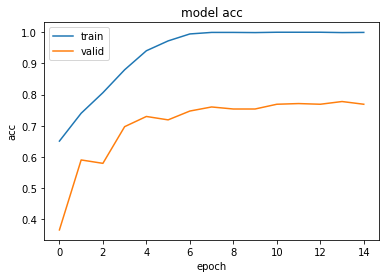

In [74]:
#now plot the learning curves
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

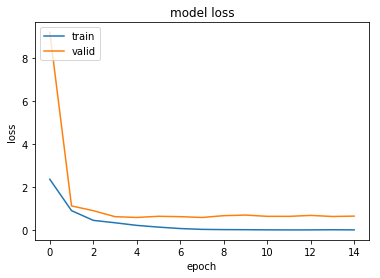

In [75]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# lets try to submit this
# before we tried to submit a 100 dense model and
# that scored pretty well

In [76]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

array([ 0.60473955,  0.99239892,  0.90256917, ...,  0.99779862,
        0.92461187,  0.82978314], dtype=float32)

In [77]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [78]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [79]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [80]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [81]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.6047395467758179
1,47,0.9923989176750183
2,966,0.9025691747665405
3,1526,0.8828146457672119
4,487,0.3911682665348053


In [84]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_may_30_2017.gz'), index=False, compression='gzip')

In [85]:
%ls -lah $DATA_DIR/results

total 69K
drwxr-x--- 2 yns207 yns207 4,0K 30 mai   14:06 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:04 subm_may_29_2017_.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:06 subm_may_30_2017.gz


In [86]:
inputs = Input(shape=(150,200,3))
m = BatchNormalization()(inputs)
m = Flatten()(m)
m = Dense(100, activation='relu')(m)
m = BatchNormalization()(m)
preds = Dense(2, activation='softmax')(m)
model = Model(inputs=inputs, outputs=preds)
model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
hist = model.fit_generator(tr_batches, 
                           steps_per_epoch=(tr_batches.n//batch_size)+1,
                           validation_data=va_batches,
                           validation_steps=(va_batches.n//batch_size)+1,
                           epochs=10
                          )

Epoch 1/10
29/29 [==============================] - 68s - loss: 2.1293 - acc: 0.6073 - val_loss: 3.9577 - val_acc: 0.6993
Epoch 2/10
29/29 [==============================] - 55s - loss: 0.5780 - acc: 0.7372 - val_loss: 1.1754 - val_acc: 0.7168
Epoch 3/10
29/29 [==============================] - 55s - loss: 0.4511 - acc: 0.8003 - val_loss: 0.6977 - val_acc: 0.7516
Epoch 4/10
29/29 [==============================] - 55s - loss: 0.3778 - acc: 0.8419 - val_loss: 0.5670 - val_acc: 0.7734
Epoch 5/10
29/29 [==============================] - 56s - loss: 0.3080 - acc: 0.8943 - val_loss: 0.6279 - val_acc: 0.7407
Epoch 6/10
29/29 [==============================] - 55s - loss: 0.2083 - acc: 0.9419 - val_loss: 0.6101 - val_acc: 0.7560
Epoch 7/10
29/29 [==============================] - 55s - loss: 0.1303 - acc: 0.9768 - val_loss: 0.8990 - val_acc: 0.6993
Epoch 8/10
29/29 [==============================] - 55s - loss: 0.0790 - acc: 0.9908 - val_loss: 0.6817 - val_acc: 0.7407
Epoch 9/10
29/29 [======

In [88]:
hist.history

{'acc': [0.60675381328545364,
  0.73801742984318786,
  0.80010893233201608,
  0.84259259207316217,
  0.89488017364265093,
  0.9422657958562598,
  0.9765795206971678,
  0.9907407407407407,
  0.99618736383442263,
  0.99346405228758172],
 'loss': [2.1362128133088154,
  0.57843277553068007,
  0.45116836670177435,
  0.37651102449379714,
  0.30728714255725637,
  0.20842472829070746,
  0.13073219740377792,
  0.079160834352175399,
  0.049836230563701886,
  0.046094403506818683],
 'val_acc': [0.69934640522875813,
  0.71677559912854028,
  0.75163398692810457,
  0.7734204793028322,
  0.7407407407407407,
  0.75599128540305016,
  0.69934640522875813,
  0.7407407407407407,
  0.73856209150326801,
  0.77124183006535951],
 'val_loss': [3.9576841918388266,
  1.1754140507080846,
  0.69773448245652625,
  0.56704868395733676,
  0.62786842361579531,
  0.61014276135850831,
  0.89904705086856884,
  0.68171958997034043,
  0.70208379949294919,
  0.62219940995988243]}

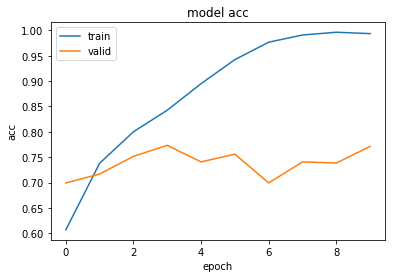

In [89]:
#now plot the learning curves
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

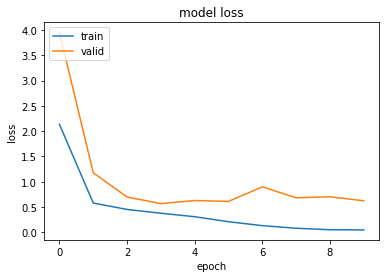

In [90]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [91]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

array([ 0.99726188,  0.94682741,  0.96147537, ...,  0.51398587,
        0.61035168,  0.96016949], dtype=float32)

In [92]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [93]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [94]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [95]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [96]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.9972618818283081
1,47,0.9468274116516113
2,966,0.9614753723144531
3,1526,0.9923864603042603
4,487,0.9077484011650085


In [97]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_may_30_2017_2.gz'), index=False, compression='gzip')

In [98]:
%ls -lah $DATA_DIR/results

total 89K
drwxr-x--- 2 yns207 yns207 4,0K 30 mai   14:56 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:04 subm_may_29_2017_.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:56 subm_may_30_2017_2.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:06 subm_may_30_2017.gz
